<center><h1><b> Wadaba Plastic Images Classification </b></h1></center>

In [1]:
# Import necessary libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pathlib  # To convert datadirectory into a pathlib that will help to convert each photo into numpy array
import PIL  # This is an image displaying library in python
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint  # to save the best epoch(weights, bias)
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Defining the input path and the output path for images
input_path = '/kaggle/input/wadaba'
output_images_path = '/kaggle/working/wadaba/images'

# To create the output folder for images if it doesn't exist
os.makedirs(output_images_path, exist_ok = True)

# Iterating through each image folder in the input path
for folder_name in os.listdir(input_path):
    folder_path = os.path.join(input_path, folder_name)
    
    # Cofirm it is a folder
    if os.path.isdir(folder_path):
        # Create corresponding folder in the images output directory
        image_dest_folder = os.path.join(output_images_path, folder_name)
        os.makedirs(image_dest_folder, exist_ok = True)
        
        # Extracting images only
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            # This is to copy the files into images folder if it an image
            if file_name.endswith('.jpg') and os.path.isfile(file_path):
                shutil.copy(file_path, image_dest_folder)
                
print('Images have been successfully extracted into the images directory.')

Images have been successfully extracted into the images directory.


In [3]:
print(os.listdir(output_images_path))

['PS', 'Other', 'PE_HD', 'PP', 'PET']


In [4]:
# Converting data directory into a pathlib
data_dir = pathlib.Path(output_images_path)
data_dir

PosixPath('/kaggle/working/wadaba/images')

In [5]:
# Check the immediate subdirectories/files
list(data_dir.glob('*'))

[PosixPath('/kaggle/working/wadaba/images/PS'),
 PosixPath('/kaggle/working/wadaba/images/Other'),
 PosixPath('/kaggle/working/wadaba/images/PE_HD'),
 PosixPath('/kaggle/working/wadaba/images/PP'),
 PosixPath('/kaggle/working/wadaba/images/PET')]

In [6]:
# Number of all images with the .jpg extension in all nested directories
len(list(data_dir.glob('**/*.jpg')))

4000

## Visualization of an image from each directory

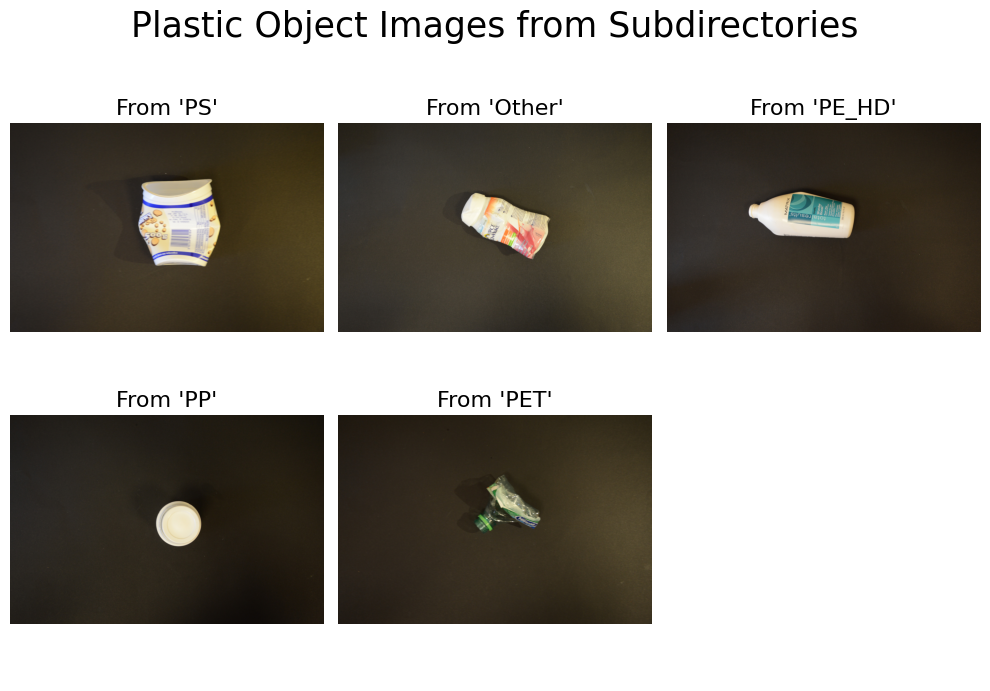

In [7]:
rows = 2
cols = 3

# Set up the subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 7))
fig.suptitle("Plastic Object Images from Subdirectories", fontsize=25)

# Flatten the axes array to easily iterate through it
axes = axes.ravel()

# Counter to keep track of the images displayed
image_count = 0

# Iterate through each subdirectory and display one image from each
for sub_dir in data_dir.iterdir():
    if sub_dir.is_dir():
        image_list = list(sub_dir.glob('*.jpg'))
        if image_list:
            # Open the first image in the subdirectory
            img = Image.open(image_list[0])
            
            # Display the image in the corresponding subplot
            axes[image_count].imshow(img)
            axes[image_count].set_title(f"From '{sub_dir.name}'", fontsize=16)
            axes[image_count].axis('off') 
            
            image_count += 1

# Remove any empty subplots
for ax in axes[image_count:]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [8]:
# Dictionary class for all the plastic object
plastic_images_dict =  {
    'pe_hd': list(data_dir.glob('PE_HD/*')),
    'ps': list(data_dir.glob('PS/*')),
    'other': list(data_dir.glob('Other/*')),
    'pp': list(data_dir.glob('PP/*')),
    'pet': list(data_dir.glob('PET/*'))
}

In [9]:
# Label dictionary
plastic_labels_dict = {
    'pe_hd': 0,
    'ps': 1,
    'other': 2,
    'pp': 3,
    'pet': 4
}

In [10]:
# Runing a for loop to view number of images in each class
for plastic_name, images in plastic_images_dict.items():
    print(f"The directory '{plastic_name}' contains {len(images)} images.")

The directory 'pe_hd' contains 600 images.
The directory 'ps' contains 520 images.
The directory 'other' contains 40 images.
The directory 'pp' contains 640 images.
The directory 'pet' contains 2200 images.


In [11]:
# Function to preprocess images, apply random oversampling, and split the data
def preprocess_and_split_data(plastic_images_dict, plastic_labels_dict, image_size, test_size=0.2, random_state=0):
    X, y = [], []
    
    # Resize images and create X, y lists
    for plastic_name, images in plastic_images_dict.items():
        for image in images:
            img = cv2.imread(str(image))
            resized_img = cv2.resize(img, image_size)
            X.append(resized_img)
            y.append(plastic_labels_dict[plastic_name])
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Reshape X for oversampling (flatten the images)
    X_reshaped = X.reshape(X.shape[0], -1)
    
    # Apply Random Oversampling to balance the dataset
    ros = RandomOverSampler(random_state=random_state)
    X_resampled, y_resampled = ros.fit_resample(X_reshaped, y)
    
    # Reshape X back to original image shape after oversampling
    X_resampled = X_resampled.reshape(-1, image_size[0], image_size[1], 3)
    
    # Scale pixel values to the range [0, 1]
    X_scaled = X_resampled / 255.0
    
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = preprocess_and_split_data(plastic_images_dict, plastic_labels_dict, image_size=(180, 180))

In [12]:
X_train.shape

(8800, 180, 180, 3)

In [13]:
X_test.shape

(2200, 180, 180, 3)

## Building Custom CNN Model

In [14]:
# Function to plot training & validation accuracy and loss curves
def plot_training_history(model):
    
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'], label='Train Accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'], label='Train Loss')
    plt.plot(model.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();

Epoch 1/40
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2442 - loss: 1.5869
Epoch 1: val_accuracy improved from -inf to 0.41955, saving model to custom_plastic_images_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.2448 - loss: 1.5862 - val_accuracy: 0.4195 - val_loss: 1.2975
Epoch 2/40
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4696 - loss: 1.2712
Epoch 2: val_accuracy improved from 0.41955 to 0.61500, saving model to custom_plastic_images_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.4700 - loss: 1.2701 - val_accuracy: 0.6150 - val_loss: 0.8769
Epoch 3/40
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5933 - loss: 0.9674
Epoch 3: val_accuracy improved from 0.61500 to 0.68727, saving model to custom_plastic_images_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5934 - loss: 0.9671 - val_accuracy: 0.6873 - val_loss: 0.6973
Epoch 4/40
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.65

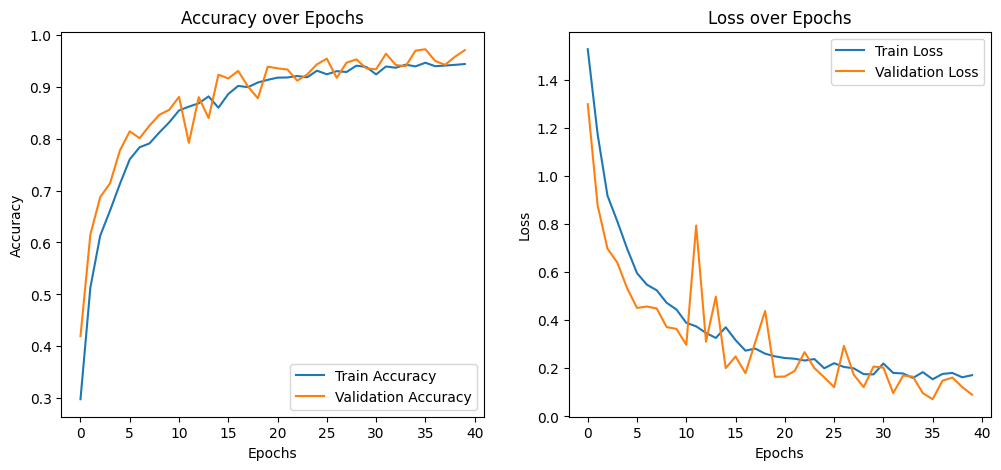

In [15]:
# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, epochs):
    # This will create a callback that saves the model with the best validation accuracy
    checkpoint_callback = ModelCheckpoint(
        'custom_plastic_images_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ) 

    num_classes = 5

    # Augmentation parameters to handle overfitting
    data_augmentation = tf.keras.Sequential([
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.5),
        layers.RandomRotation(0.2),
        layers.RandomFlip("horizontal_and_vertical")
    ])

    model = Sequential([
        data_augmentation,
        
        # CNN Layers
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Flatten layer
        layers.Flatten(),
        
        # Dense Layers with Dropout
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout to reduce overfitting (50%)
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # Dropout to reduce overfitting (50%)
        
        # Output layer with Softmax activation
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model with validation data and the checkpoint callback
    custom_model = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[checkpoint_callback]) 

    # The best model saved by ModelCheckpoint will be loaded
    best_model = load_model('custom_plastic_images_model.keras')

    # Evaluate the best model on the test data
    loss, accuracy = best_model.evaluate(X_test, y_test)
    print(f'Best Accuracy: {accuracy * 100:.2f}%')
    print(f'Best Loss: {loss:.4f}') 

    # Plot the training history
    plot_training_history(custom_model)


train_and_evaluate_model(X_train, y_train, X_test, y_test, epochs=40)


## Making predictions and displaying the predicted images and the actual images

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


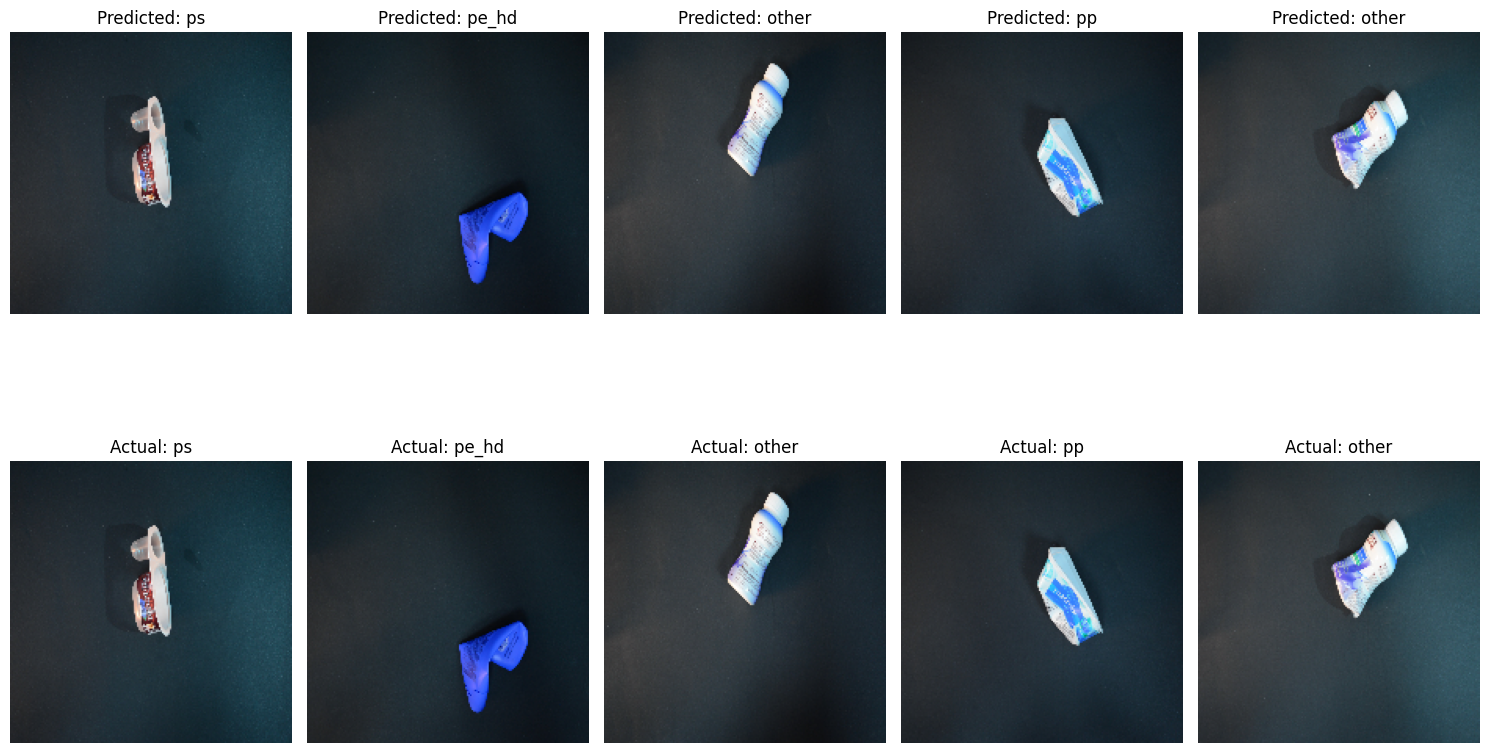

In [16]:
# Function to compare the predicted images and the actual images
def predictions_and_actuals(model, X_test, y_test, labels_dict, num_images=5):
    # Make predictions on the test set
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Create a reverse mapping from numeric labels to string labels
    reverse_labels_dict = {v: k for k, v in labels_dict.items()}

    # Figure for displaying images
    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        
        # Display the predicted image (rescaling as necessary)
        img_pred = X_test[i]
        if img_pred.max() <= 1.0:
            img_pred = (img_pred * 255).astype('uint8')  # Rescale to [0, 255]
        
        # Display the predicted image and its label
        plt.imshow(img_pred)
        plt.axis('off')
        plt.title(f'Predicted: {reverse_labels_dict[predicted_classes[i]]}')

        # Display the actual image
        plt.subplot(2, num_images, i + 1 + num_images)
        
        # The image corresponding to the actual label
        img_actual = X_test[i]  # You can update this if actuals are from a different set
        
        # Rescale the actual image as well if necessary
        if img_actual.max() <= 1.0:
            img_actual = (img_actual * 255).astype('uint8')

        plt.imshow(img_actual)
        plt.axis('off')
        plt.title(f'Actual: {reverse_labels_dict[y_test[i]]}')

    plt.tight_layout()
    plt.show()


# The best model saved by ModelCheckpoint will be loaded
custom_best_model = load_model('custom_plastic_images_model.keras')

# Calling the function to display predicted and actual labels
predictions_and_actuals(custom_best_model, X_test, y_test, plastic_labels_dict)

## Classification Report and Confusion Matrix Visualization

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
              precision    recall  f1-score   support

       pe_hd       1.00      1.00      1.00       466
          ps       0.95      0.97      0.96       405
       other       1.00      1.00      1.00       439
          pp       0.94      0.95      0.94       452
         pet       0.97      0.95      0.96       438

    accuracy                           0.97      2200
   macro avg       0.97      0.97      0.97      2200
weighted avg       0.97      0.97      0.97      2200

************************************************************


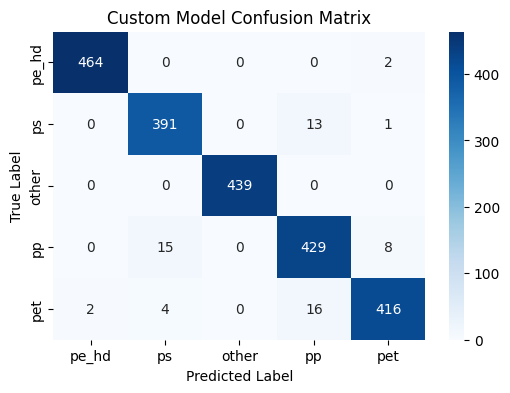

In [17]:
def class_report_and_con_matrix(model, X_test, y_test, labels_dict):
    # Predict the classes for the test set
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1) 

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, predicted_classes, target_names=labels_dict.keys()))
    print("****" * 15)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_dict.keys(), yticklabels=labels_dict.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Custom Model Confusion Matrix')
    plt.show()

# The best model saved by ModelCheckpoint will be loaded
custom_best_model = load_model('custom_plastic_images_model.keras')

class_report_and_con_matrix(custom_best_model, X_test, y_test, plastic_labels_dict)

In [18]:
# Function to calculate overall precision, recall, f1-score, and accuracy
def model_metrics(model, X_test, y_test):
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Convert probabilities to class labels (for multi-class classification)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate overall accuracy, precision, recall, and F1-score (macro average)
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='macro')
    recall = recall_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')

    # Printing the results
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    return accuracy, precision, recall, f1


model_metrics(custom_best_model, X_test, y_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 97.23%
Precision: 0.9721
Recall: 0.9720
F1-score: 0.9720


(0.9722727272727273,
 0.9720573579354894,
 0.9720053974034748,
 0.9719848421600453)

------------------------------

<center><h2> MobileNet Model</h2></center>

In [19]:
# Function to preprocess images and split the data
def process_data(plastic_images_dict, plastic_labels_dict, image_size=(224, 224), test_size=0.2, random_state=0):
    X, y = [], []
    
    for plastic_name, images in plastic_images_dict.items():
        for image in images:
            img = cv2.imread(str(image))
            resized_img = cv2.resize(img, image_size)
            X.append(resized_img)
            y.append(plastic_labels_dict[plastic_name])
    
    # Convert lists to arrays and scale the images
    X = np.array(X) / 255.0
    y = np.array(y)

    # Split data into training and test sets
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


X_train, X_test, y_train, y_test = process_data(plastic_images_dict, plastic_labels_dict)


print(f'X_tran: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_tran: (3200, 224, 224, 3)
X_test: (800, 224, 224, 3)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,602,693 (9.93 MB)

 Trainable params: 344,709 (1.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5271 - loss: 1.3344
Epoch 1: val_accuracy improved from -inf to 0.79125, saving model to mobilenetv2_1.00_224_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.5287 - loss: 1.3287 - val_accuracy: 0.7912 - val_loss: 0.5793
Epoch 2/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7290 - loss: 0.7115
Epoch 2: val_accuracy did not improve from 0.79125
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7292 - loss: 0.7104 - val_accuracy: 0.7850 - val_loss: 0.5347
Epoch 3/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7777 - loss: 0.5630
Epoch 3: val_accuracy improved from 0.79125 to 0.85000, saving model to mobilenetv2_1.00_224_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7776 - loss: 0.5630 - val_accuracy: 0.8500 - val_loss: 0.3865
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7854 - loss: 0.5385
Epoch 4: val_accuracy di

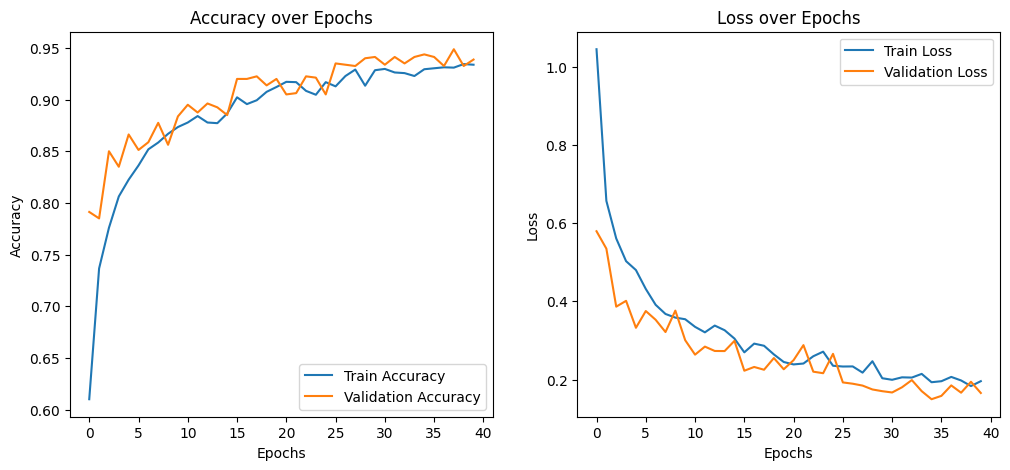

In [20]:
# Function to build and train a model using any Keras base model (like MobileNetV2 or ResNet50)
def train_and_evaluate_model(X_train, y_train, X_test, y_test, base_model, epochs):
    
    # Dynamically create the model filename based on the base model's class name
    model_name = base_model.name.lower()
    model_filename = f'{model_name}_best_model.keras'


    # Save the best model based on validation accuracy
    checkpoint_callback = ModelCheckpoint(
        model_filename,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ) 

    num_classes = 5

    # Data augmentation layer
    data_augmentation = Sequential([
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.5),
        layers.RandomRotation(0.2),
        layers.RandomFlip("horizontal_and_vertical")
    ])

    # Freezing the base model to prevent training it
    base_model.trainable = False
    
    # Building the full model with custom layers
    model = Sequential([
        data_augmentation,

        base_model,

        layers.GlobalAveragePooling2D(),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.build(input_shape=(None, 224, 224, 3))
    
    print(model.summary())

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    trained_model = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

    # Load the best model saved by ModelCheckpoint
    best_model = load_model(model_filename)

    # Evaluate the model on the test set
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
    print(f'Best Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Best Loss: {test_loss:.4f}')

    # Plot training and validation history
    plot_training_history(trained_model)


# MobileNetV2, base model
mobilenet_base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet')

# Call the function with the desired base model and number of epochs
train_and_evaluate_model(X_train, y_train, X_test, y_test, mobilenet_base_model, epochs=40)

## Mobilenet Model Prediction, and metrics

In [21]:
# Function to load saved model
def load_saved_model(base_model):
    # Generates the filename using the base model's class name
    model_name = base_model.name.lower()
    model_filename = f'{model_name}_best_model.keras'


    # Load the saved model from file
    try:
        model = load_model(model_filename)
        print(f'Successfully loaded {model_name} model.')
        return model
    except OSError:
        print(f'Model file {model_filename} not found.')
        return None


# Loading MobileNetV2 model
mobilenet_base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')

mobilenet_loaded_model = load_saved_model(mobilenet_base_model)

Successfully loaded mobilenetv2_1.00_224 model.


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


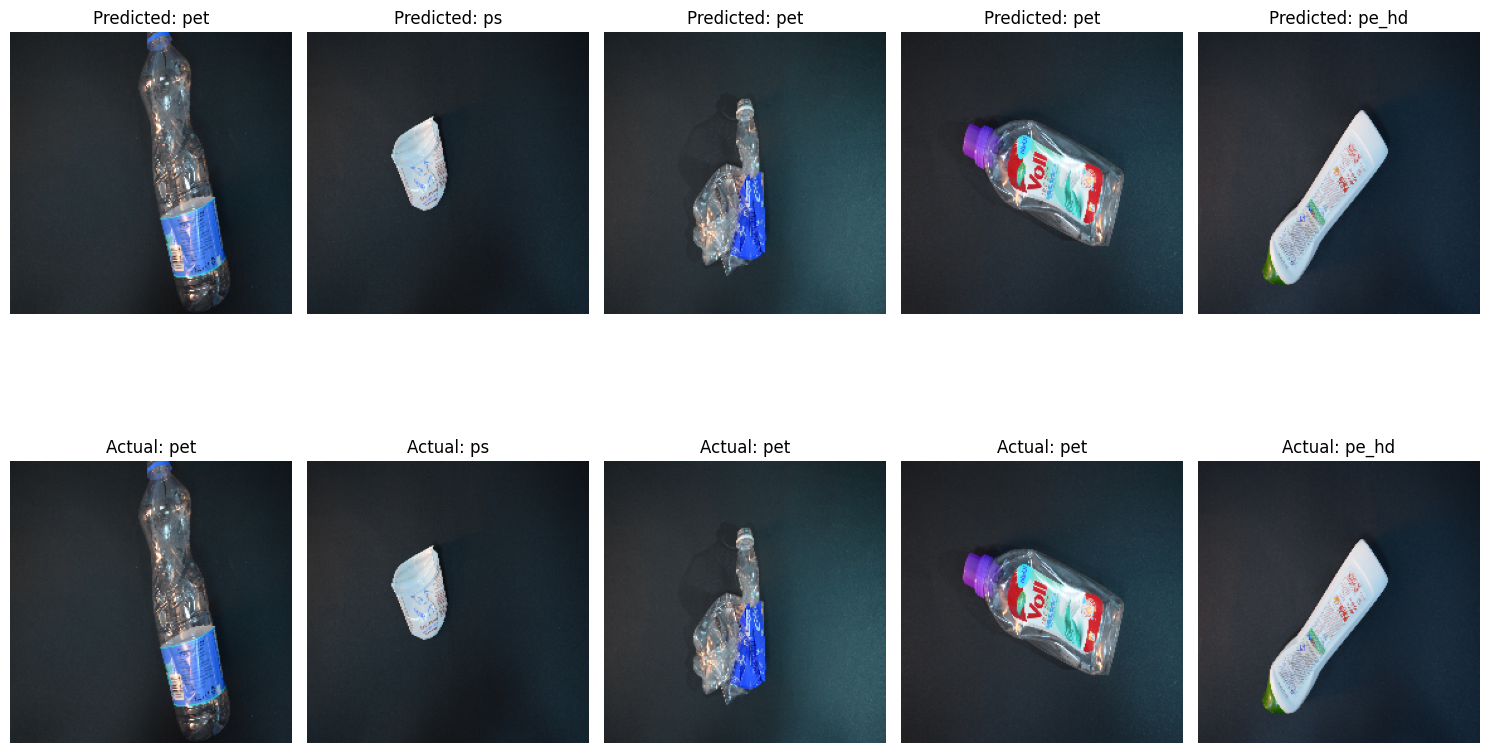

In [22]:
# Displaying predictions and labels
predictions_and_actuals(mobilenet_loaded_model, X_test, y_test, plastic_labels_dict)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Classification Report:
              precision    recall  f1-score   support

       pe_hd       0.99      0.94      0.96       139
          ps       0.86      0.92      0.89       106
       other       0.75      0.60      0.67         5
          pp       0.89      0.85      0.87       124
         pet       0.98      0.99      0.98       426

    accuracy                           0.95       800
   macro avg       0.89      0.86      0.87       800
weighted avg       0.95      0.95      0.95       800

************************************************************


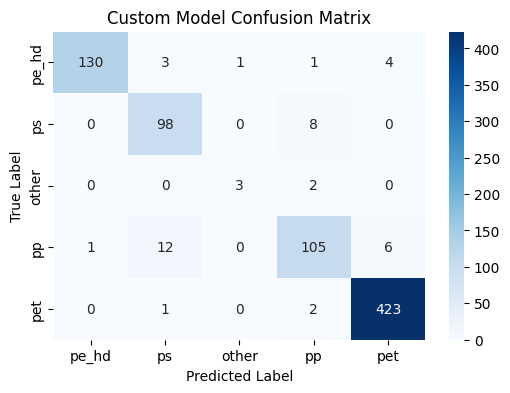

In [23]:
# Mobilenet classification report and confusion matrix
class_report_and_con_matrix(mobilenet_loaded_model, X_test, y_test, plastic_labels_dict)

In [24]:
# Mobilenet model metrics
model_metrics(mobilenet_loaded_model, X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy: 94.88%
Precision: 0.8938
Recall: 0.8599
F1-score: 0.8746


(0.94875, 0.8937502710547249, 0.8599024080950407, 0.8746346877958688)

-------------------------------

<center><h2> ResNet50 Model</h2></center>

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,129,029 (92.04 MB)

 Trainable params: 541,317 (2.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4636 - loss: 1.4668
Epoch 1: val_accuracy improved from -inf to 0.53250, saving model to resnet50_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.4640 - loss: 1.4657 - val_accuracy: 0.5325 - val_loss: 1.2514
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5182 - loss: 1.2933
Epoch 2: val_accuracy did not improve from 0.53250
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.5185 - loss: 1.2930 - val_accuracy: 0.5325 - val_loss: 1.2158
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5602 - loss: 1.2383
Epoch 3: val_accuracy improved from 0.53250 to 0.53500, saving model to resnet50_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.5602 - loss: 1.2383 - val_accuracy: 0.5350 - val_loss: 1.1880
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5487 - loss: 1.2427
Epoch 4: val_accuracy improved from 0.53500

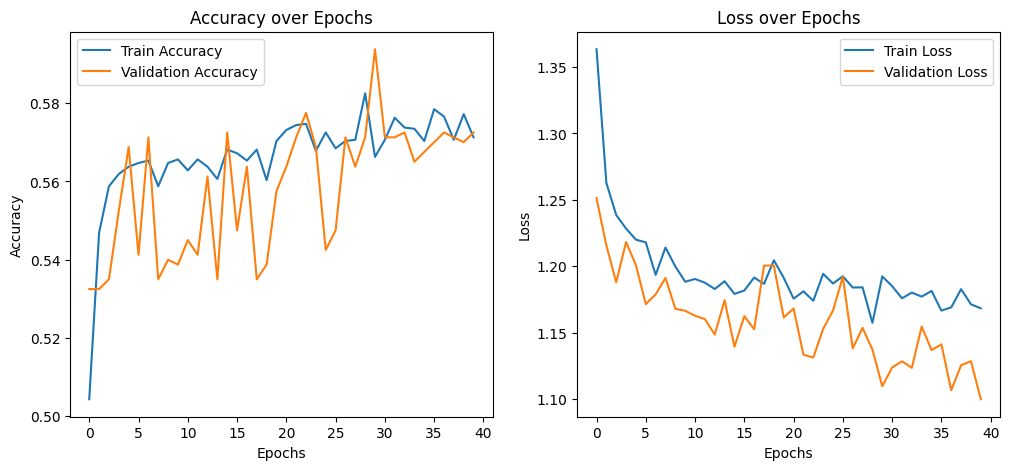

In [25]:
# ResNet50 base model
resnet_base_model = tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet')

# Calling the model trainng function 
train_and_evaluate_model(X_train, y_train, X_test, y_test, resnet_base_model, epochs=40)

## ResNet50 Model Prediction, and metrics

Successfully loaded resnet50 model.
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


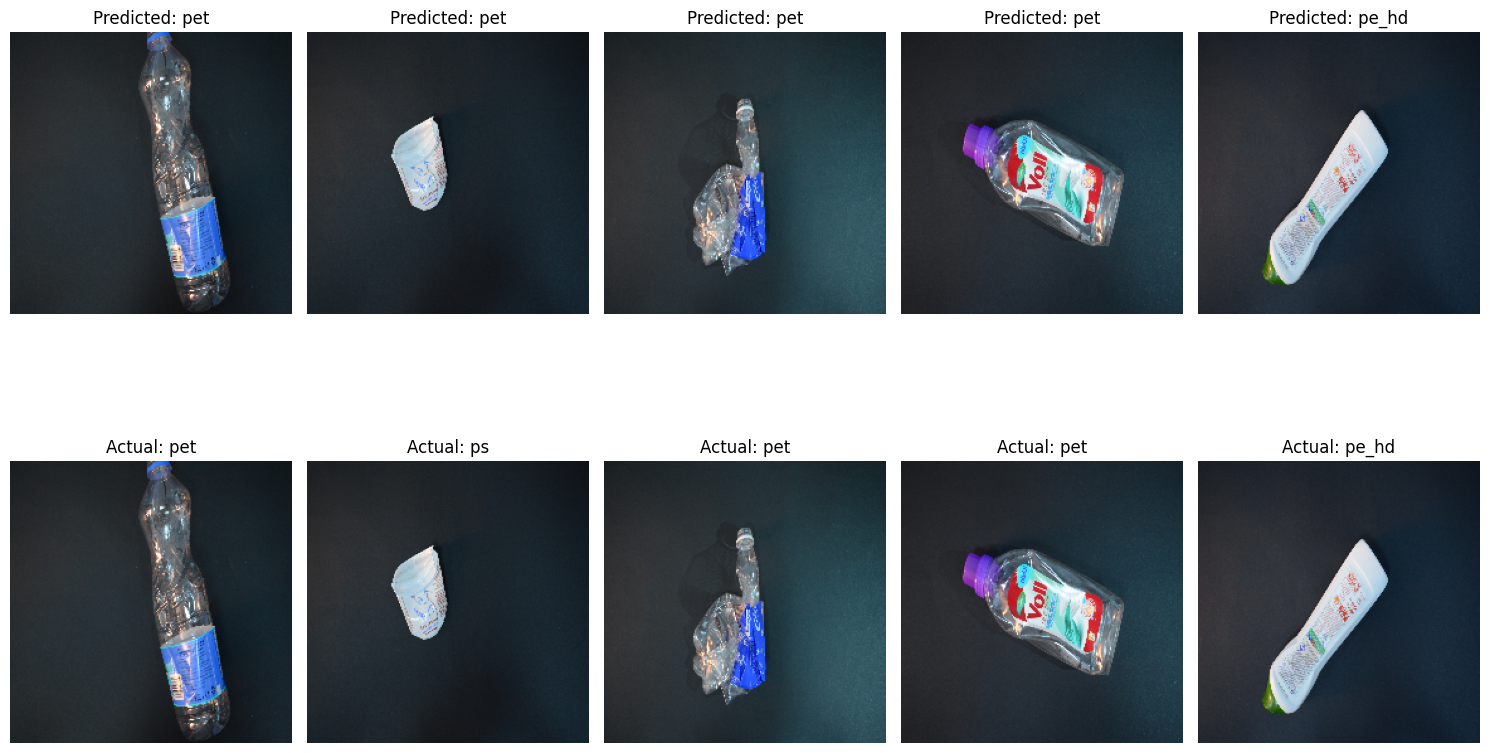

In [26]:
# loading ResNet50 model
resnet_base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')

# Resnet50 best model saved by ModelCheckpoint will be loaded
resnet_loaded_model = load_saved_model(resnet_base_model)


# Displaying predictions and labels
predictions_and_actuals(resnet_loaded_model, X_test, y_test, plastic_labels_dict)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Classification Report:
              precision    recall  f1-score   support

       pe_hd       0.57      0.47      0.51       139
          ps       0.00      0.00      0.00       106
       other       0.00      0.00      0.00         5
          pp       0.00      0.00      0.00       124
         pet       0.60      0.96      0.74       426

    accuracy                           0.59       800
   macro avg       0.23      0.29      0.25       800
weighted avg       0.42      0.59      0.48       800

************************************************************


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


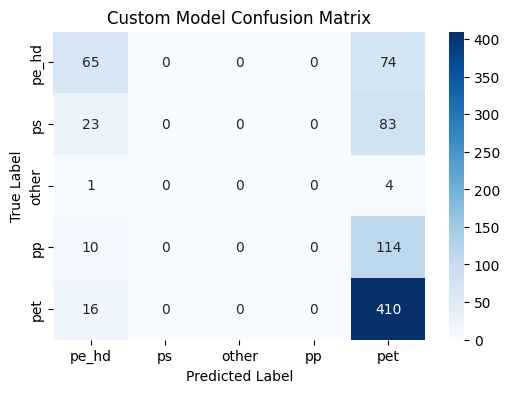

In [27]:
class_report_and_con_matrix(resnet_loaded_model, X_test, y_test, plastic_labels_dict)

In [28]:
model_metrics(resnet_loaded_model, X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Accuracy: 59.38%
Precision: 0.2328
Recall: 0.2860
F1-score: 0.2500


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.59375, 0.23275150745794987, 0.28601344276691326, 0.249976966200557)

-----------------------

<center><h2> EfficientNet Model</h2></center>

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,394,280 (16.76 MB)

 Trainable params: 344,709 (1.31 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/40


2024-10-23 08:03:56.665272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5062 - loss: 1.3671
Epoch 1: val_accuracy improved from -inf to 0.53250, saving model to efficientnetb0_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.5065 - loss: 1.3666 - val_accuracy: 0.5325 - val_loss: 1.2452
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5470 - loss: 1.2698
Epoch 2: val_accuracy did not improve from 0.53250
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5471 - loss: 1.2698 - val_accuracy: 0.5325 - val_loss: 1.2375
Epoch 3/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5463 - loss: 1.2660
Epoch 3: val_accuracy did not improve from 0.53250
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5464 - loss: 1.2658 - val_accuracy: 0.5325 - val_loss: 1.2340
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5463 - loss: 1.2573
Epoch 4: val_accuracy did not improve from 0.53250
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy:

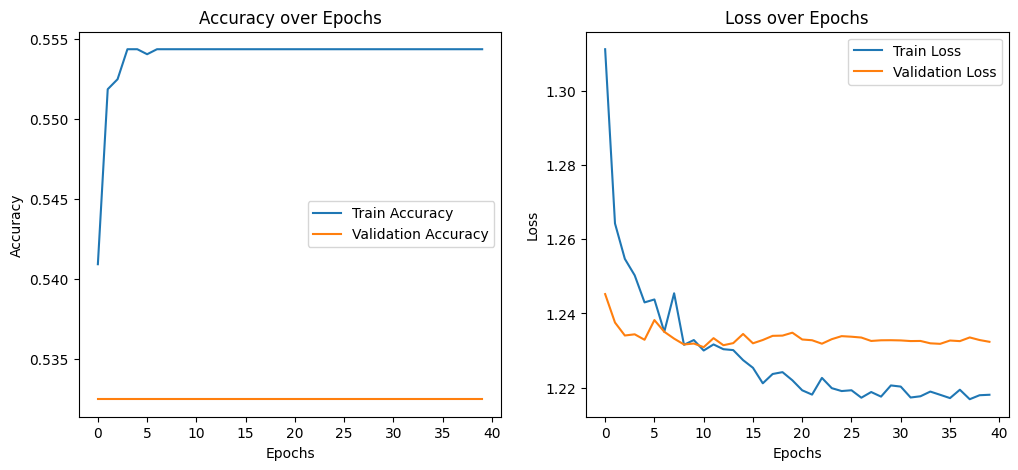

In [29]:
efficientnet_base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')

# Call the function with EfficientNetB0 base model and number of epochs
train_and_evaluate_model(X_train, y_train, X_test, y_test, efficientnet_base_model, epochs=40)

## EfficientNet Model Prediction, and metrics

Successfully loaded efficientnetb0 model.
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


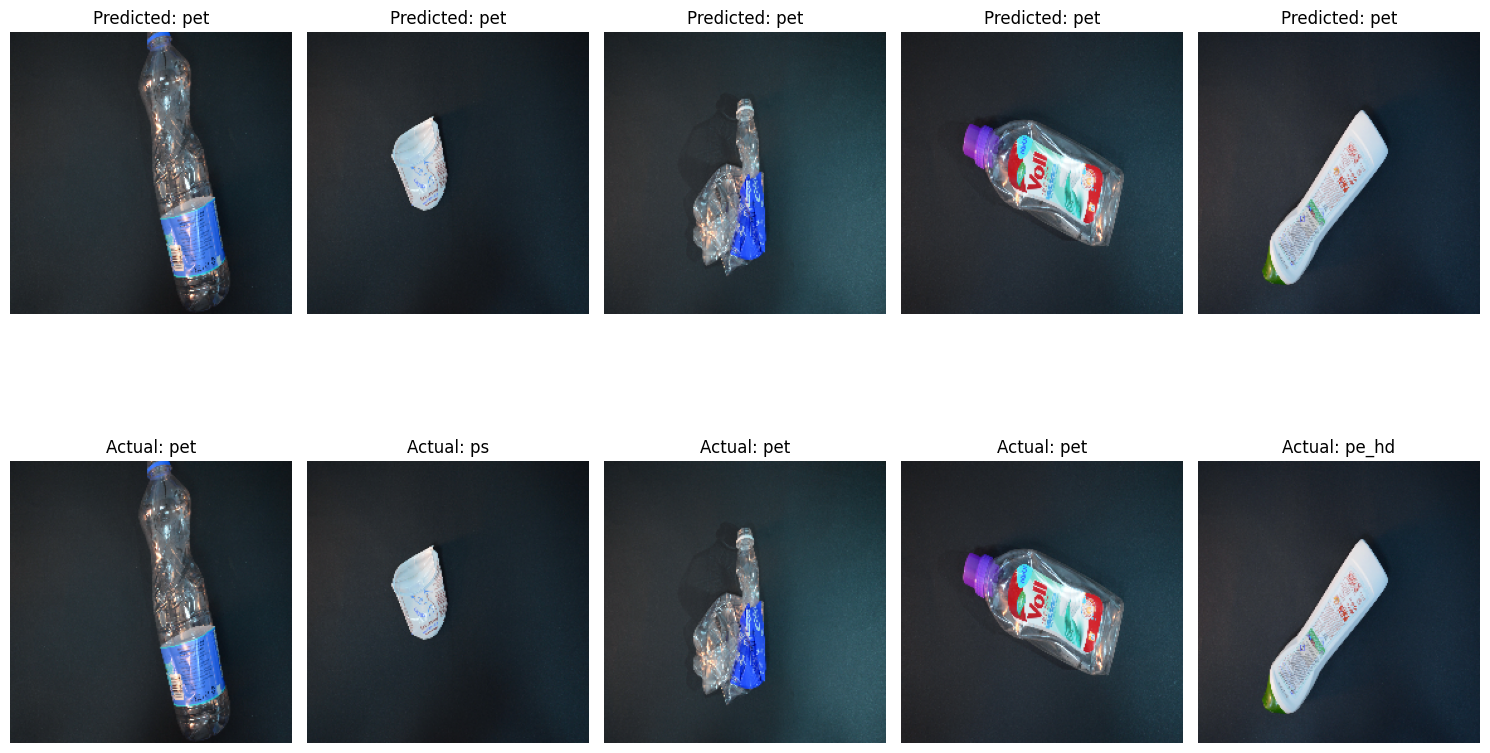

In [30]:
# Loading Efficient model
efficientnet_base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')

# Resnet50 best model saved by ModelCheckpoint will be loaded
efficient_loaded_model = load_saved_model(efficientnet_base_model)


# Displaying predictions and labels
predictions_and_actuals(efficient_loaded_model, X_test, y_test, plastic_labels_dict)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Classification Report:
              precision    recall  f1-score   support

       pe_hd       0.00      0.00      0.00       139
          ps       0.00      0.00      0.00       106
       other       0.00      0.00      0.00         5
          pp       0.00      0.00      0.00       124
         pet       0.53      1.00      0.69       426

    accuracy                           0.53       800
   macro avg       0.11      0.20      0.14       800
weighted avg       0.28      0.53      0.37       800

************************************************************


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


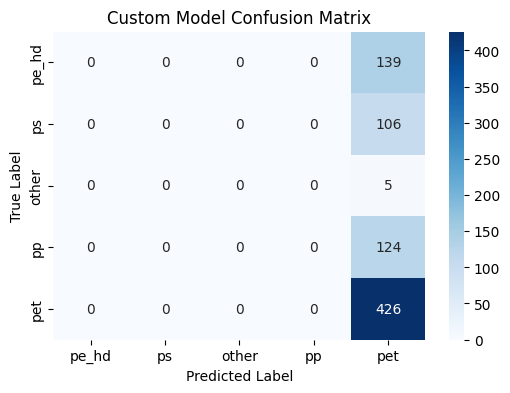

In [31]:
class_report_and_con_matrix(efficient_loaded_model, X_test, y_test, plastic_labels_dict)

In [32]:
model_metrics(efficient_loaded_model, X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Accuracy: 53.25%
Precision: 0.1065
Recall: 0.2000
F1-score: 0.1390


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5325, 0.1065, 0.2, 0.13898858075040782)